In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import re
import string
import urllib
import gzip
import time
import nltk
import gensim 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from collections import Counter

from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Flatten, MaxPool1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Data Gathering

In [ ]:
real_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/real.csv")
real_news.head()

,Unnamed: 0,Unnamed: 0.1,id,title,publication,author,date,year,month,url,content
0,0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
2,9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...
3,2547,2547,20127,U.S. Plans to Step Up Military Campaign Agains...,New York Times,Michael S. Schmidt and Eric Schmitt,2016-12-21,2016.0,12.0,NaN,"ABU DHABI, United Arab Emirates — The Obama..."
4,2551,2551,20131,272 Slaves Were Sold to Save Georgetown. What ...,New York Times,Rachel L. Swarns,2016-12-15,2016.0,12.0,NaN,WASHINGTON — The human cargo was loaded on ...


In [ ]:
fake_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/fake.csv")
fake_news.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [ ]:
# essential columns
fake_news1 = fake_news[['title', 'text','language','site_url']]
fake_news1 = fake_news1[fake_news1.language == 'english']
fake_news1['title'].fillna(value="", inplace=True)

# drop null 'text' rows as there is no context of the article
fake_news1.dropna(axis=0, inplace=True, subset=['text'])

# data shuffling and resetting index to avoid bias
fake_news1 = fake_news1.sample(frac=1.0) 
fake_news1.reset_index(drop=True,inplace=True)
fake_news1.head()

,title,text,language,site_url
0,,Put the women in charge. Maybe PEACE will brea...,english,anonhq.com
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,english,barenakedislam.com
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,english,godlikeproductions.com
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,english,katehon.com
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",english,kingworldnews.com


In [ ]:
#feature extraction
fake_news2 = fake_news1[['title', 'text','site_url']]

#data labelling
fake_news2['label'] = 'fake'
fake_news2.head()

,title,text,site_url,label
0,,Put the women in charge. Maybe PEACE will brea...,anonhq.com,fake
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,barenakedislam.com,fake
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,godlikeproductions.com,fake
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,katehon.com,fake
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",kingworldnews.com,fake


In [ ]:
#all site_urls
site_urls = fake_news2['site_url']

#removing domain extensions
site_urls2 = [x.split('.',1)[0] for x in site_urls]

#replacing the old site_url column with these values
fake_news2['site_url'] = site_urls2
fake_news2.head()

,title,text,site_url,label
0,,Put the women in charge. Maybe PEACE will brea...,anonhq,fake
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,barenakedislam,fake
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,godlikeproductions,fake
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,katehon,fake
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",kingworldnews,fake


In [ ]:
#feature extraction
real_news2 = real_news[['title', 'content', 'publication']]

#data labelling
real_news2['label'] = 'real'
real_news2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


In [ ]:
#rename features in our final datasets
newlabels = ['title', 'content', 'publication', 'label']
real_news2.columns = newlabels
fake_news2.columns = newlabels

In [ ]:
fake_news2.head()

,title,content,publication,label
0,,Put the women in charge. Maybe PEACE will brea...,anonhq,fake
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,barenakedislam,fake
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,godlikeproductions,fake
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,katehon,fake
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",kingworldnews,fake


In [ ]:
real_news2.head()

,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


#Data Concatenation

In [ ]:
#dataframe combined to form a new final Fake News Detection dataset
dataframes = [fake_news2, real_news2]
final_dataset = pd.concat(dataframes)

# Fill any null fields
final_dataset.title.fillna("", inplace=True)
final_dataset.content.fillna("", inplace=True)

final_dataset

,title,content,publication,label
0,,Put the women in charge. Maybe PEACE will brea...,anonhq,fake
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,barenakedislam,fake
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,godlikeproductions,fake
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,katehon,fake
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",kingworldnews,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 15711
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        28069 non-null  object
 1   content      28069 non-null  object
 2   publication  28069 non-null  object
 3   label        28069 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [ ]:
final_dataset['label'] = final_dataset['label'].map({'real': 1, 'fake': 0})
final_dataset

,title,content,publication,label
0,,Put the women in charge. Maybe PEACE will brea...,anonhq,0
1,WHITE FLIGHT? Or is it white fright? British m...,BNI Store Nov 2 2016 WHITE FLIGHT? Or is it wh...,barenakedislam,0
2,Black and a member of the 1% elite,Black and a member of the 1% elite Page 1 Rela...,godlikeproductions,0
3,Strikes of the Syrian aircraft on the Al Nusra...,Home » Strikes of the Syrian aircraft on the A...,katehon,0
4,Top Citi Analyst Issues Important Update On Th...,"20 Views November 03, 2016 GOLD , KWN King Wor...",kingworldnews,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,1


In [ ]:
final_dataset['content'] = final_dataset['title'] + " " + final_dataset['content']
final_dataset

,title,content,publication,label
0,,Put the women in charge. Maybe PEACE will bre...,anonhq,0
1,WHITE FLIGHT? Or is it white fright? British m...,WHITE FLIGHT? Or is it white fright? British m...,barenakedislam,0
2,Black and a member of the 1% elite,Black and a member of the 1% elite Black and a...,godlikeproductions,0
3,Strikes of the Syrian aircraft on the Al Nusra...,Strikes of the Syrian aircraft on the Al Nusra...,katehon,0
4,Top Citi Analyst Issues Important Update On Th...,Top Citi Analyst Issues Important Update On Th...,kingworldnews,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,An eavesdropping Uber driver saved his 16-year...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Plane carrying six people returning from a Cav...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,After helping a fraction of homeowners expecte...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...","Yes, this is real: Michigan just banned bannin...",Washington Post,1


#Data Pre-Processing

In [ ]:
final_dataset = final_dataset[['content','label']]
final_dataset

,content,label
0,Put the women in charge. Maybe PEACE will bre...,0
1,WHITE FLIGHT? Or is it white fright? British m...,0
2,Black and a member of the 1% elite Black and a...,0
3,Strikes of the Syrian aircraft on the Al Nusra...,0
4,Top Citi Analyst Issues Important Update On Th...,0
...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,1
15708,Plane carrying six people returning from a Cav...,1
15709,After helping a fraction of homeowners expecte...,1
15710,"Yes, this is real: Michigan just banned bannin...",1


Now remove extra characters

In [ ]:
def preprocess_text(df, remove_special=True):
    texts = df['content'].copy()
    labels = df['label'].copy()

    #Remove links 
    df["content"] = df["content"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["content"] = df["content"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
        
    #Strip Punctation
    df["content"] = df["content"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert content to lowercase
    df["content"] = df["content"].apply(lambda x: x.lower())
        
    #Remove multiple letter repeating words
    df["content"] = df["content"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(final_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["content"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 28069
After : Number of posts 27472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#Vectorization - Word2Vec

gensim library

In [ ]:
## Dependent features
y=new_df['label'].values
# array is printed
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
## Independent Features
X = new_df.drop('label',axis=1)
X = [d.split() for d in new_df['content'].tolist()]

X[0]

['white',
 'flight',
 'eostokenquest',
 'white',
 'fright',
 'eostokenquest',
 'british',
 'multiculturalism',
 'created',
 'segregation',
 'towns',
 'where',
 'white',
 'population',
 'fleeing',
 'muslim',
 'population',
 'exploding',
 'store',
 'white',
 'flight',
 'eostokenquest',
 'white',
 'fright',
 'eostokenquest',
 'british',
 'multiculturalism',
 'created',
 'segregation',
 'towns',
 'where',
 'white',
 'population',
 'fleeing',
 'muslim',
 'population',
 'exploding',
 'white',
 'mainly',
 'muslim',
 'minority',
 'groups',
 'more',
 'isolated',
 'from',
 'each',
 'other',
 'than',
 'ever',
 'before',
 'while',
 'white',
 'populations',
 'towns',
 'cities',
 'have',
 'sunk',
 'record',
 'lows',
 'less',
 'than',
 'last',
 'decade',
 'alone',
 'been',
 'revealed',
 'eostokendot',
 'express',
 'newham',
 'east',
 'london',
 'just',
 'cent',
 'population',
 'white',
 'compared',
 'cent',
 'years',
 'eostokendot',
 'blackburn',
 'ranked',
 'most',
 'segregated',
 'town',
 'britain'

In [ ]:
#array
print(type(y))
#list of list
print(type(X),type(X[0]))

<class 'numpy.ndarray'>
<class 'list'> <class 'list'>


Using Gensim Library

In [ ]:
#dimension - each word converted to a sequence of _DIM_ vectors
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
# Vocabulary size - unique words for which the vectors are created
len(w2v_model.wv.vocab)

159335

* The following vectors are going to be fed as INITIAL weight in the DL modeland THEN, 
* DL model will retrain these weights - to maximize accuracy. 
Better results as compared to directly inputting them in the model

In [ ]:
# print(w2v_model.wv['hiliary'])
# print(w2v_model.wv.most_similar['hiliary'])

##Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)
# seq. no. is assigned for each word. Check is by running:
# tokenizer.word_index
X[0]

[83,
 1749,
 21,
 83,
 26513,
 21,
 742,
 10336,
 680,
 7372,
 2624,
 55,
 83,
 676,
 3852,
 754,
 676,
 9529,
 1661,
 83,
 1749,
 21,
 83,
 26513,
 21,
 742,
 10336,
 680,
 7372,
 2624,
 55,
 83,
 676,
 3852,
 754,
 676,
 9529,
 83,
 2891,
 754,
 1492,
 276,
 13,
 4074,
 6,
 206,
 30,
 24,
 252,
 63,
 56,
 83,
 3467,
 2624,
 838,
 4,
 10187,
 517,
 6131,
 186,
 24,
 60,
 1338,
 865,
 17,
 1195,
 1,
 2379,
 52667,
 472,
 1104,
 29,
 7675,
 676,
 83,
 1163,
 7675,
 39,
 1,
 19263,
 6207,
 43,
 10188,
 762,
 1302,
 55,
 96780,
 1533,
 497,
 7675,
 16,
 754,
 328,
 12442,
 2188,
 115,
 1001,
 83,
 307,
 530,
 35,
 22,
 1,
 5748,
 96781,
 96782,
 1619,
 22088,
 12442,
 2838,
 60,
 59,
 7,
 651,
 911,
 83,
 16,
 20,
 8,
 1493,
 191,
 22,
 309,
 31,
 91,
 1,
 111,
 2,
 312,
 6649,
 5,
 351,
 21,
 754,
 617,
 25,
 312,
 112,
 497,
 206,
 30,
 128,
 104,
 65,
 83,
 16,
 303,
 1,
 2,
 4075,
 1354,
 312,
 6649,
 29,
 18,
 1054,
 1,
 105,
 312,
 5,
 497,
 41,
 321,
 7865,
 617,
 69,
 321,
 206,
 

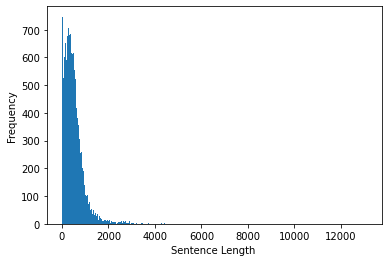

In [ ]:
plt.hist([len(i) for i in X] , bins = 700)
plt.xlabel('Sentence Length ',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.show()

In [ ]:
num = np.array([len(i) for i in X])
len(num[num>1500])

932

In [ ]:
#Remove posts with less than 1500 words
max_words = 1500
X = pad_sequences(X, maxlen=max_words)

Not all word sequences will be generated by the gensim model. Some are unknown words can be present in the a new data, hence we add +1 for them.

#DL Model: LSTM

Word Embedding

In [ ]:
### Vocabulary Size
voc_size = len(tokenizer.word_index) + 1
### Vocabulary 
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((voc_size, DIM)) #tuple

  for word,i in vocab.items():
    weight_matrix[i] = model.wv[word]
  
  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape

(159336, 100)

In [ ]:
#Creating the Model
model=Sequential()
#vector feature size = DIM
model.add(Embedding(voc_size, output_dim=DIM, weights=[embedding_vectors], input_length=max_words, trainable=False ))

#Dropout not added yet
model.add(LSTM(units=100))

#Dense layer added as it is a classification problem - 1 final output in the end
#sigmoid as we have only 2 classes - 0 & 1, else use softmax
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 100)         15933600  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 16,014,101
Trainable params: 80,501
Non-trainable params: 15,933,600
_________________________________________________________________
None


#67-33 Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=6,batch_size=64)

Epoch 1/6
288/288 [==============================] - 73s 231ms/step - loss: 0.4363 - accuracy: 0.7959 - val_loss: 0.4152 - val_accuracy: 0.8233
Epoch 2/6
288/288 [==============================] - 66s 229ms/step - loss: 0.3250 - accuracy: 0.8585 - val_loss: 0.3022 - val_accuracy: 0.8722
Epoch 3/6
288/288 [==============================] - 67s 232ms/step - loss: 0.2600 - accuracy: 0.8921 - val_loss: 0.2765 - val_accuracy: 0.8865
Epoch 4/6
288/288 [==============================] - 66s 228ms/step - loss: 0.2605 - accuracy: 0.8878 - val_loss: 0.2737 - val_accuracy: 0.8886
Epoch 5/6
288/288 [==============================] - 67s 232ms/step - loss: 0.1933 - accuracy: 0.9222 - val_loss: 0.3149 - val_accuracy: 0.8760
Epoch 6/6
288/288 [==============================] - 66s 228ms/step - loss: 0.1562 - accuracy: 0.9406 - val_loss: 0.2684 - val_accuracy: 0.8918


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int32")

In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test,y_pred),2))

The Accuracy Score Is :  0.89


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(print(classification_report(y_test,y_pred)))

[[3372  546]
 [ 435 4713]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3918
           1       0.90      0.92      0.91      5148

    accuracy                           0.89      9066
   macro avg       0.89      0.89      0.89      9066
weighted avg       0.89      0.89      0.89      9066

None


##**DETECTION**

1.27.23 -> https://www.youtube.com/watch?v=eLjs52-gsJQ&t=3595s 


## Adding Droupout

In [ ]:
from tensorflow.keras.layers import Dropout
## Creating model
model=Sequential()
model.add(Embedding(voc_size, output_dim=DIM, weights=[embedding_vectors], input_length=max_words, trainable=False ))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dropout(0.3))
#sigmoid as we have only 2 classes - 0 & 1, else use softmax
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 100)         15933600  
                                                                 
 dropout (Dropout)           (None, 1500, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16,014,101
Trainable params: 80,501
Non-trainable params: 15,933,600
_________________________________________________________________
None


In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42)

history1 = model.fit(X_train1,y_train1,validation_data=(X_test1,y_test1),epochs=6,batch_size=64)

Epoch 1/6
288/288 [==============================] - 70s 235ms/step - loss: 0.4768 - accuracy: 0.7722 - val_loss: 0.3641 - val_accuracy: 0.8463
Epoch 2/6
288/288 [==============================] - 66s 230ms/step - loss: 0.3661 - accuracy: 0.8416 - val_loss: 0.3141 - val_accuracy: 0.8690
Epoch 3/6
288/288 [==============================] - 66s 230ms/step - loss: 0.3501 - accuracy: 0.8457 - val_loss: 0.3073 - val_accuracy: 0.8662
Epoch 4/6
288/288 [==============================] - 66s 230ms/step - loss: 0.3020 - accuracy: 0.8692 - val_loss: 0.2890 - val_accuracy: 0.8736
Epoch 5/6
288/288 [==============================] - 66s 230ms/step - loss: 0.2789 - accuracy: 0.8831 - val_loss: 0.3070 - val_accuracy: 0.8744
Epoch 6/6
288/288 [==============================] - 66s 231ms/step - loss: 0.2746 - accuracy: 0.8863 - val_loss: 0.2869 - val_accuracy: 0.8736


In [ ]:
y_pred1 = (model.predict(X_test1) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_test1,y_pred1)

array([[3177,  741],
       [ 405, 4743]])

In [ ]:
#accuracy_score(y_test,y_pred)
print('The Accuracy Score Is : ',round(accuracy_score(y_test1,y_pred1),2))

The Accuracy Score Is :  0.87


In [ ]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3918
           1       0.86      0.92      0.89      5148

    accuracy                           0.87      9066
   macro avg       0.88      0.87      0.87      9066
weighted avg       0.87      0.87      0.87      9066



#70-30 Split

In [ ]:
#model=Sequential()
#model.add(Embedding(voc_size, output_dim=DIM, weights=[embedding_vectors], input_length=max_words, trainable=False ))
#model.add(LSTM(units=100))
##sigmoid as we have only 2 classes - 0 & 1, else use softmax
#model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#print(model.summary())

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
history2 = model.fit(X_train2,y_train2,validation_data=(X_test2,y_test2),epochs=6, batch_size=64)

Epoch 1/6
301/301 [==============================] - 68s 227ms/step - loss: 0.2652 - accuracy: 0.8912 - val_loss: 0.2812 - val_accuracy: 0.8835
Epoch 2/6
301/301 [==============================] - 70s 232ms/step - loss: 0.2473 - accuracy: 0.8982 - val_loss: 0.2660 - val_accuracy: 0.8934
Epoch 3/6
301/301 [==============================] - 68s 226ms/step - loss: 0.2334 - accuracy: 0.9059 - val_loss: 0.2573 - val_accuracy: 0.8937
Epoch 4/6
301/301 [==============================] - 68s 226ms/step - loss: 0.2225 - accuracy: 0.9101 - val_loss: 0.2879 - val_accuracy: 0.8781
Epoch 5/6
301/301 [==============================] - 68s 226ms/step - loss: 0.2208 - accuracy: 0.9102 - val_loss: 0.2756 - val_accuracy: 0.8936
Epoch 6/6
301/301 [==============================] - 68s 226ms/step - loss: 0.2025 - accuracy: 0.9190 - val_loss: 0.3058 - val_accuracy: 0.8771


In [ ]:
y_pred2 = (model.predict(X_test2) >= 0.5).astype("int32")

In [ ]:
confusion_matrix(y_test2,y_pred2)

array([[3368,  170],
       [ 843, 3861]])

In [ ]:
#accuracy_score(y_test,y_pred)
print('The Accuracy Score Is : ',round(accuracy_score(y_test2,y_pred2),2))

The Accuracy Score Is :  0.88


In [ ]:
print(classification_report(y_test2,y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      3538
           1       0.96      0.82      0.88      4704

    accuracy                           0.88      8242
   macro avg       0.88      0.89      0.88      8242
weighted avg       0.89      0.88      0.88      8242



#80-20 Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
history3 = model.fit(X_train3,y_train3,validation_data=(X_test3,y_test3),epochs=6,batch_size=64)

Epoch 1/6
344/344 [==============================] - 74s 214ms/step - loss: 0.2054 - accuracy: 0.9185 - val_loss: 0.2609 - val_accuracy: 0.8997
Epoch 2/6
344/344 [==============================] - 74s 215ms/step - loss: 0.2023 - accuracy: 0.9177 - val_loss: 0.2298 - val_accuracy: 0.9063
Epoch 3/6
344/344 [==============================] - 78s 228ms/step - loss: 0.1815 - accuracy: 0.9279 - val_loss: 0.2563 - val_accuracy: 0.9012
Epoch 4/6
344/344 [==============================] - 74s 214ms/step - loss: 0.1705 - accuracy: 0.9339 - val_loss: 0.1983 - val_accuracy: 0.9258
Epoch 5/6
344/344 [==============================] - 73s 214ms/step - loss: 0.1608 - accuracy: 0.9385 - val_loss: 0.1924 - val_accuracy: 0.9197
Epoch 6/6
344/344 [==============================] - 74s 214ms/step - loss: 0.1594 - accuracy: 0.9379 - val_loss: 0.1912 - val_accuracy: 0.9208


In [ ]:
y_pred3 = (model.predict(X_test3) >= 0.5).astype("int32")

In [ ]:
confusion_matrix(y_test3,y_pred3)

array([[2209,  147],
       [ 288, 2851]])

In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test3,y_pred3),2))

The Accuracy Score Is :  0.92


In [ ]:
print(classification_report(y_test3,y_pred3))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2356
           1       0.95      0.91      0.93      3139

    accuracy                           0.92      5495
   macro avg       0.92      0.92      0.92      5495
weighted avg       0.92      0.92      0.92      5495



#50-50 split

In [ ]:
from sklearn.model_selection import train_test_split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
history4 =  model.fit(X_train4,y_train4,validation_data=(X_test4,y_test4),epochs=6,batch_size=64)

Epoch 1/6
215/215 [==============================] - 57s 264ms/step - loss: 0.1489 - accuracy: 0.9437 - val_loss: 0.1712 - val_accuracy: 0.9308
Epoch 2/6
215/215 [==============================] - 57s 264ms/step - loss: 0.1495 - accuracy: 0.9442 - val_loss: 0.1531 - val_accuracy: 0.9442
Epoch 3/6
215/215 [==============================] - 63s 293ms/step - loss: 0.1325 - accuracy: 0.9488 - val_loss: 0.1503 - val_accuracy: 0.9421
Epoch 4/6
215/215 [==============================] - 57s 265ms/step - loss: 0.1307 - accuracy: 0.9515 - val_loss: 0.1815 - val_accuracy: 0.9311
Epoch 5/6
215/215 [==============================] - 57s 264ms/step - loss: 0.1321 - accuracy: 0.9516 - val_loss: 0.2186 - val_accuracy: 0.9174
Epoch 6/6
215/215 [==============================] - 57s 265ms/step - loss: 0.1132 - accuracy: 0.9581 - val_loss: 0.1478 - val_accuracy: 0.9443


In [ ]:
y_pred4 = (model.predict(X_test4) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_test4,y_pred4)

array([[5605,  319],
       [ 446, 7366]])

In [ ]:
#accuracy_score(y_test,y_pred)
print('The Accuracy Score Is : ',round(accuracy_score(y_test4,y_pred4),2))

The Accuracy Score Is :  0.94


In [ ]:
print(classification_report(y_test4,y_pred4))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5924
           1       0.96      0.94      0.95      7812

    accuracy                           0.94     13736
   macro avg       0.94      0.94      0.94     13736
weighted avg       0.94      0.94      0.94     13736



#30-70 Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.7, random_state=42)

In [ ]:
history5 = model.fit(X_train5,y_train5,validation_data=(X_test5,y_test5),epochs=6,batch_size=64)

Epoch 1/6
129/129 [==============================] - 46s 354ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.2360 - val_accuracy: 0.9207
Epoch 2/6
129/129 [==============================] - 46s 358ms/step - loss: 0.0814 - accuracy: 0.9688 - val_loss: 0.1442 - val_accuracy: 0.9497
Epoch 3/6
129/129 [==============================] - 46s 354ms/step - loss: 0.0677 - accuracy: 0.9752 - val_loss: 0.2103 - val_accuracy: 0.9291
Epoch 4/6
129/129 [==============================] - 45s 351ms/step - loss: 0.0721 - accuracy: 0.9727 - val_loss: 0.1559 - val_accuracy: 0.9509
Epoch 5/6
129/129 [==============================] - 45s 351ms/step - loss: 0.0671 - accuracy: 0.9750 - val_loss: 0.2041 - val_accuracy: 0.9372
Epoch 6/6
129/129 [==============================] - 45s 352ms/step - loss: 0.0696 - accuracy: 0.9745 - val_loss: 0.1875 - val_accuracy: 0.9397


In [ ]:
y_pred5 = (model.predict(X_test5) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_test5,y_pred5)

array([[ 8050,   240],
       [  920, 10021]])

In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test5,y_pred5),2))

The Accuracy Score Is :  0.94


In [ ]:
print(classification_report(y_test5,y_pred5))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      8290
           1       0.98      0.92      0.95     10941

    accuracy                           0.94     19231
   macro avg       0.94      0.94      0.94     19231
weighted avg       0.94      0.94      0.94     19231



#Comparision

In [ ]:
score_1 = accuracy_score(y_test1,y_pred1)
score_2 = accuracy_score(y_test2,y_pred2)
score_3 = accuracy_score(y_test3,y_pred3)
score_4 = accuracy_score(y_test4,y_pred4)
score_5 = accuracy_score(y_test5,y_pred5)
results = pd.DataFrame([["80:20 split",format(score_3*100,".2f")],["70:30 split",format(score_2*100,".2f")], ["67:33 split",format(score_1*100,".2f")],
                       ["50:50 split",format(score_4*100,".2f")],["30:70 split",format(score_5*100,".2f")]], columns=["Train:Test Split","Accuracy (%)"])
results

,Train:Test Split,Accuracy (%)
0,80:20 split,92.08
1,70:30 split,87.71
2,67:33 split,87.36
3,50:50 split,94.43
4,30:70 split,93.97


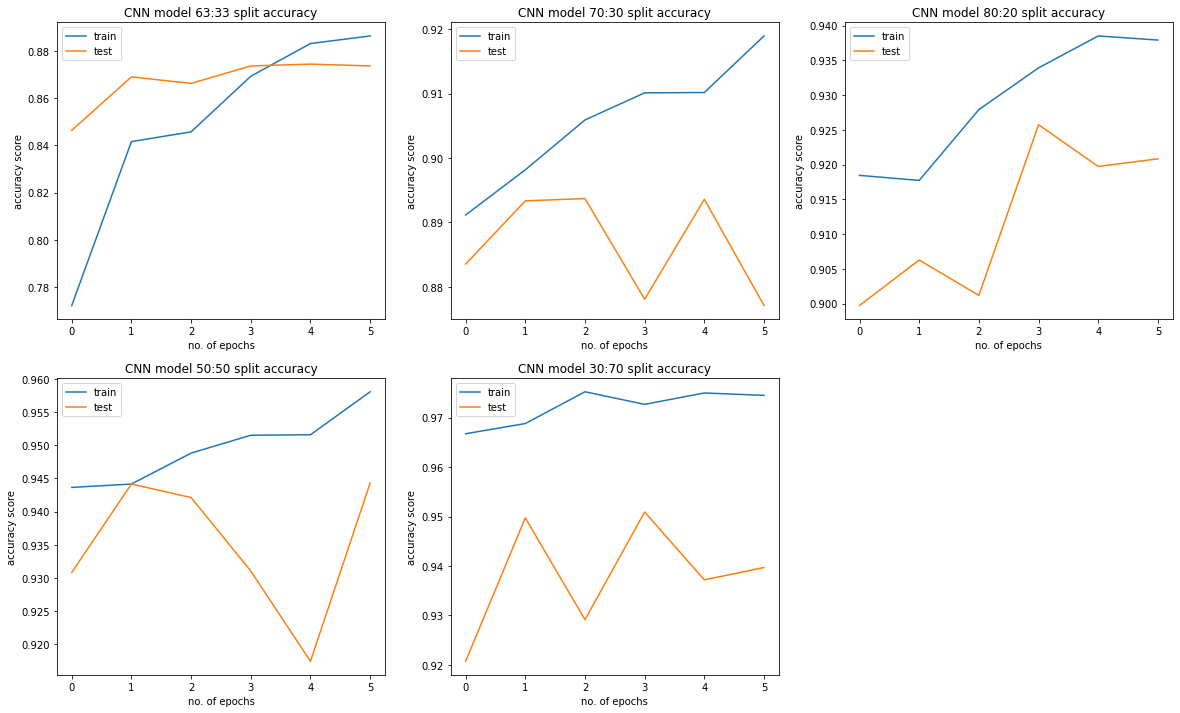

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('LSTM model 63:33 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('LSTM model 70:30 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('LSTM model 80:20 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('LSTM model 50:50 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('LSTM model 30:70 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

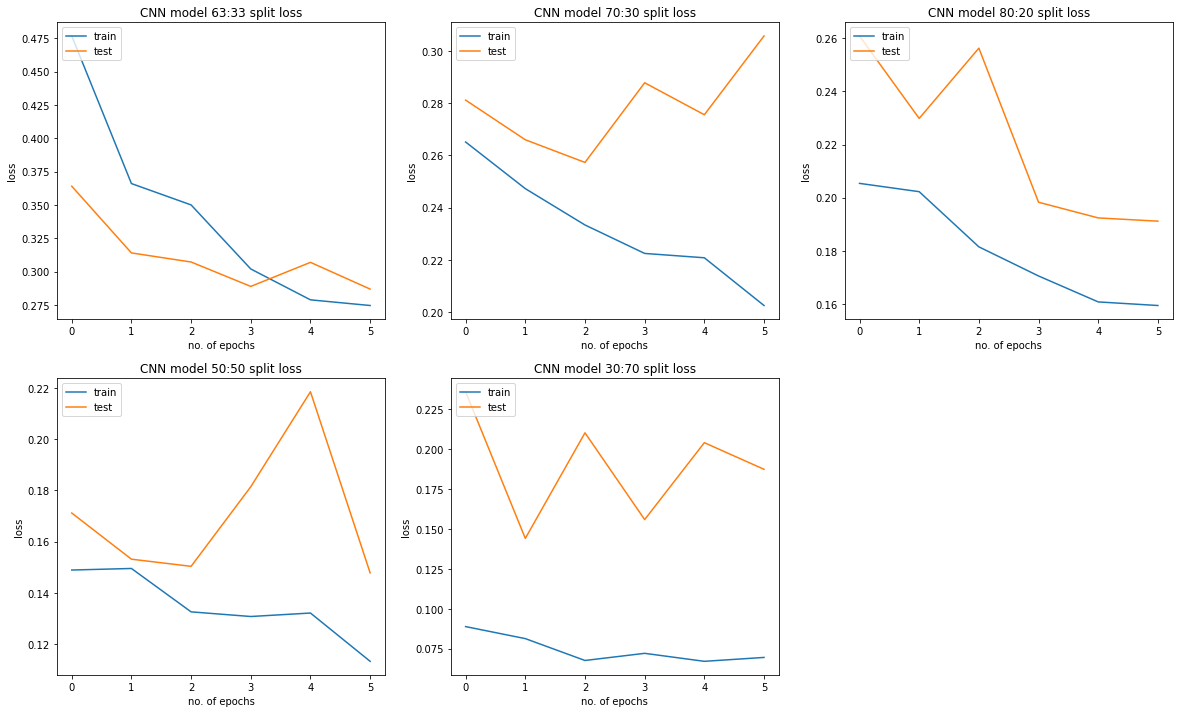

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('LSTM model 63:33 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('LSTM model 70:30 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('LSTM model 80:20 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('LSTM model 50:50 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('LSTM model 30:70 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()